In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
#data from https://www.kaggle.com/mrmorj/hate-speech-and-offensive-language-dataset?select=labeled_data.csv
url = 'https://raw.githubusercontent.com/BrokenPeter/HateSpeechClassifier/main/data/labeled_data_1.csv'


df1 = pd.read_csv(url)
#format of original dataset is like this:
print(df1.head())

   Unnamed: 0  count  ...  class                                              tweet
0           0      3  ...      2  !!! RT @mayasolovely: As a woman you shouldn't...
1           1      3  ...      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2           2      3  ...      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3           3      3  ...      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4           4      6  ...      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

[5 rows x 7 columns]


In [ ]:
#take only label and text
b=df1['class']
df1.rename(columns={'tweet' : 'text'}, inplace=True)
a=df1['text']
df= pd.concat([a,b], axis=1)
print(df.head(),"\n\n")
print(df.groupby('class').count())

                                                text  class
0  !!! RT @mayasolovely: As a woman you shouldn't...      2
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1 


        text
class       
0       1430
1      19190
2       4163


In [ ]:
a = df.loc[df['class']==0]
b = df.loc[df['class']==2]
b.loc[:,'class'] = 1
rslt_df = pd.concat([a,b], axis=0)
rslt_df = rslt_df.reset_index(drop=True)
rslt_df.rename(columns={'class' : 'label'}, inplace=True)
print(rslt_df.groupby('label').count())
print(rslt_df.head())
df = rslt_df

       text
label      
0      1430
1      4163
                                                text  label
0  "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...      0
1  "@CB_Baby24: @white_thunduh alsarabsss" hes a ...      0
2  "@DevilGrimz: @VigxRArts you're fucking gay, b...      0
3  "@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...      0
4  "@NoChillPaz: "At least I'm not a nigger" http...      0


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,    
)
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_train:', np.bincount(y_val))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y_train: [1158 3371]
Labels counts in y_train: [129 375]
Labels counts in y_test: [143 417]


In [ ]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

df_train = df.loc[df["data_type"]=="train"]
df_val = df.loc[df["data_type"]=="val"]
df_test = df.loc[df["data_type"]=="test"]
print(df_train.head(5))
print(df_val.head(5))
print(df_test.head(5))

                                                text  label data_type
0  "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...      0     train
1  "@CB_Baby24: @white_thunduh alsarabsss" hes a ...      0     train
2  "@DevilGrimz: @VigxRArts you're fucking gay, b...      0     train
3  "@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...      0     train
4  "@NoChillPaz: "At least I'm not a nigger" http...      0     train
                                                 text  label data_type
5   "@NotoriousBM95: @_WhitePonyJr_ Ariza is a sna...      0       val
11  "@jgabsss: Stacey Dash won &#128166; http://t....      0       val
16  "Nah its You @NoMeek_JustMilz: &#128514;&#1285...      0       val
33                    #Dutch farmers are white trash.      0       val
42              #SouthCarolina is full of white trash      0       val
                                                 text  label data_type
13  "Hey go look at that video of the man that fou...      0      test
14  "Let's k

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

In [ ]:
train_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [ ]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [ ]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
#Let's try the preprocessing model on some text and see the output:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262915  0.99280983 -0.18611857  0.3667384   0.15233715  0.6550451
  0.9681154  -0.948627    0.00216166 -0.9877732   0.06842688 -0.9763059 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946406  0.34321284  0.33231527 ...  0.21300796  0.7102072
  -0.05771175]
 [-0.2874205   0.31981015 -0.23018587 ...  0.5845504  -0.21329752
   0.72692037]
 [-0.66157055  0.68876845 -0.8743293  ...  0.1087724  -0.26173186
   0.47855398]
 ...
 [-0.22561164 -0.28925577 -0.07064409 ...  0.47565955  0.8327713
   0.40025365]
 [-0.29824203 -0.2747312  -0.05450513 ...  0.4884973   1.0955358
   0.18163405]
 [-0.44378182  0.00930732  0.07223705 ...  0.17290123  1.1833236
   0.07897992]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

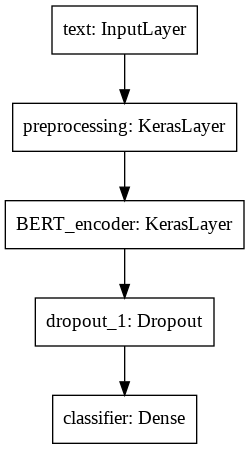

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
142/142 [==============================] - 1151s 8s/step - loss: 0.4947 - binary_accuracy: 0.7676 - val_loss: 0.2241 - val_binary_accuracy: 0.8909
Epoch 2/5
142/142 [==============================] - 1139s 8s/step - loss: 0.1894 - binary_accuracy: 0.9255 - val_loss: 0.1629 - val_binary_accuracy: 0.9286
Epoch 3/5
142/142 [==============================] - 1141s 8s/step - loss: 0.1243 - binary_accuracy: 0.9593 - val_loss: 0.1495 - val_binary_accuracy: 0.9544
Epoch 4/5
142/142 [==============================] - 1142s 8s/step - loss: 0.0983 - binary_accuracy: 0.9682 - val_loss: 0.1688 - val_binary_accuracy: 0.9345
Epoch 5/5
142/142 [==============================] - 1141s 8s/step - loss: 0.0752 - binary_accuracy: 0.9752 - val_loss: 0.1680 - val_binary_accuracy: 0.9425


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

18/18 [==============================] - 39s 2s/step - loss: 0.1591 - binary_accuracy: 0.9375
Loss: 0.15908870100975037
Accuracy: 0.9375


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


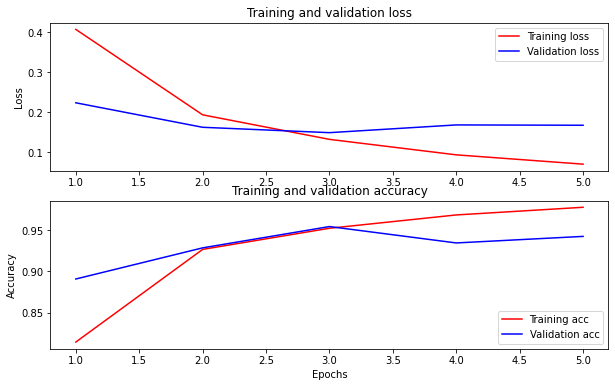

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'ds1_t1_opt'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=True)

NameError: ignored

In [ ]:
%ls

ds1_t1_bert/  model.png  sample_data/


In [ ]:
print(df.head())
print(df.groupby(['label', 'data_type']).count())

                                                text  label data_type
0  "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...      0     train
1  "@CB_Baby24: @white_thunduh alsarabsss" hes a ...      0     train
2  "@DevilGrimz: @VigxRArts you're fucking gay, b...      0     train
3  "@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...      0     train
4  "@NoChillPaz: "At least I'm not a nigger" http...      0     train
                 text
label data_type      
0     test        143
      train      1158
      val         129
1     test        417
      train      3371
      val         375


In [ ]:
df.to_csv('df1.csv',index=False)

In [ ]:
%ls

df1.csv  ds1_t1_bert/  model.png  sample_data/


In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%ls /content/drive/MyDrive/'Year 4'/ELEC4848

 Books/           data/      notebooks.zip
 code/            env.gdoc   package-list.txt
'Course Stuff'/   model/    'SDP Mid Term Report.gdoc'


In [ ]:
%ls

df1.csv  drive/  ds1_t1_bert/  model.png  sample_data/


In [ ]:
!cp df1.csv '/content/drive/MyDrive/Year 4/ELEC4848/data'

In [ ]:
%cp ds1_t1_bert/ '/content/drive/MyDrive/Year 4/ELEC4848/model/ds1_t1_bert/' -r

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
